### Teste de treinamento do VGG16

In [ ]:
# Conjunto de Importações
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
import mimetypes
import argparse
import imutils
import os

In [ ]:
# Caminho do DIRETÓRIO contendo imagens de treinamento
IMAGES_PATH = os.path.sep.join(["/kaggle/input/car-object-detection/data/training_images"])

# Caminho para .CSV contendo o as annotations das bounding boxes
ANNOTS_PATH = os.path.sep.join(["/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv"])

In [ ]:
# Diretório base
BASE_OUTPUT = "output"

os.makedirs(BASE_OUTPUT, exist_ok=True)

# Caminho para salvar o modelo treinado
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "models/"])

# Caminho para salvar o plot do histórico de treinamento
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

# Caminho da lista de filenames de teste
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

### Carregando dataset (teste)

In [ ]:
# Lendo o conteúdo das annotations (.csv) e dividindo em linhas
rows = open(ANNOTS_PATH).read().strip().split("\n")

# Listas de dados, alvos e filenames
data = []
targets = []
filenames = []


In [5]:
rows[:5]

['image,xmin,ymin,xmax,ymax',
 'vid_4_1000.jpg,281.2590449,187.0350708,327.7279305,223.225547',
 'vid_4_10000.jpg,15.16353111,187.0350708,120.3299566,236.4301802',
 'vid_4_10040.jpg,239.1924747,176.7648005,361.9681621,236.4301802',
 'vid_4_10020.jpg,496.4833575,172.3632561,630.0202605,231.5395753']

### Loop sobre as linhas

In [6]:
# Iterate through each row in the annotations data starting from the second row
for row in rows[1:]:
    # Split the row into individual values
    row = row.split(",")
    # Extract filename, bounding box coordinates (startX, startY, endX, endY)
    (filename, startX, startY, endX, endY) = row
    # Construct the path to the image
    imagePath = os.path.join(IMAGES_PATH, filename)
    # Read the image using OpenCV
    image = cv2.imread(imagePath)
    # Get the height and width of the image
    (h, w) = image.shape[:2]
    # Normalize the bounding box coordinates
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    # Load and preprocess the image using Keras
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    # Append the preprocessed image, target coordinates, and filename to their respective lists
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)


In [7]:
data[:2]

[array([[[127., 210., 254.],
         [127., 210., 254.],
         [128., 211., 255.],
         ...,
         [ 98., 181., 251.],
         [103., 184., 249.],
         [100., 183., 251.]],
 
        [[129., 212., 254.],
         [128., 211., 255.],
         [129., 212., 255.],
         ...,
         [104., 182., 255.],
         [104., 181., 251.],
         [104., 182., 255.]],
 
        [[129., 212., 254.],
         [129., 212., 254.],
         [129., 212., 254.],
         ...,
         [102., 184., 255.],
         [103., 182., 255.],
         [101., 184., 254.]],
 
        ...,
 
        [[ 29.,  53.,  81.],
         [ 27.,  50.,  81.],
         [ 27.,  50.,  81.],
         ...,
         [ 22.,  44.,  68.],
         [ 21.,  43.,  67.],
         [ 22.,  44.,  68.]],
 
        [[ 28.,  52.,  80.],
         [ 28.,  52.,  80.],
         [ 29.,  53.,  81.],
         ...,
         [ 21.,  43.,  67.],
         [ 21.,  43.,  67.],
         [ 21.,  43.,  67.]],
 
        [[ 28.,  51.,  82.],
 

In [8]:
targets[:5]

[(0.416063675887574, 0.4921975547368421, 0.4848046309171598, 0.58743565),
 (0.022431259038461538,
  0.4921975547368421,
  0.17800289437869823,
  0.6221846847368421),
 (0.35383502174556214,
  0.46517052763157896,
  0.5354558610946745,
  0.6221846847368421),
 (0.7344428365384615,
  0.4535875160526316,
  0.9319826338757395,
  0.6093146718421053),
 (0.02460202605029586,
  0.49091055342105266,
  0.19609261937869824,
  0.6273326897368421)]

In [9]:
filenames[:5]

['vid_4_1000.jpg',
 'vid_4_10000.jpg',
 'vid_4_10040.jpg',
 'vid_4_10020.jpg',
 'vid_4_10060.jpg']

### Divisão do dataset (90% treinamento e 10% teste)

In [10]:
# Convert the list of images to a NumPy array and normalize pixel values
data = np.array(data, dtype="float32") / 255.0

# Convert the list of targets to a NumPy array
targets = np.array(targets, dtype="float32")

# Split the data into training and testing sets along with filenames
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

# Save the list of testing filenames to a file
with open(TEST_FILENAMES, "w") as f:
    f.write("\n".join(testFilenames))


In [11]:
trainImages[:2]

array([[[[0.41960785, 0.6862745 , 0.9254902 ],
         [0.42352942, 0.6901961 , 0.9372549 ],
         [0.42745098, 0.69411767, 0.9411765 ],
         ...,
         [0.4117647 , 0.6509804 , 0.90588236],
         [0.4117647 , 0.6509804 , 0.90588236],
         [0.4117647 , 0.6509804 , 0.90588236]],

        [[0.42352942, 0.6901961 , 0.9372549 ],
         [0.43529412, 0.7019608 , 0.9490196 ],
         [0.43137255, 0.69803923, 0.94509804],
         ...,
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ]],

        [[0.43137255, 0.69803923, 0.94509804],
         [0.43529412, 0.7019608 , 0.9490196 ],
         [0.4392157 , 0.7058824 , 0.9529412 ],
         ...,
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ]],

        ...,

        [[0.10588235, 0.09803922, 0.10196079],
         [0.1764706 , 0.14901961, 0.10980392]

In [12]:
trainTargets[:5]

array([[6.1505067e-01, 4.7417954e-01, 7.8219968e-01, 5.8743566e-01],
       [8.9507961e-01, 4.6388352e-01, 1.0000000e+00, 5.7456565e-01],
       [7.2358898e-04, 5.1793760e-01, 9.4066568e-02, 5.9901863e-01],
       [3.8494936e-01, 5.1793760e-01, 5.6005788e-01, 6.2347168e-01],
       [5.3095412e-01, 4.9469721e-01, 6.3947558e-01, 5.8148479e-01]],
      dtype=float32)

In [13]:
trainFilenames[:5]

['vid_4_6440.jpg',
 'vid_4_2080.jpg',
 'vid_4_2060.jpg',
 'vid_4_23000.jpg',
 'vid_4_8680.jpg']

In [14]:
testFilenames[:4]

['vid_4_17540.jpg', 'vid_4_6360.jpg', 'vid_4_12300.jpg', 'vid_4_21240.jpg']

### Construção da arquitetura do modelo

In [ ]:
# Carregamento do modelo pré-treinado VGG16 (ImageNet), excluindo os layers totalmente conectados
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# "Travando" os pesos do modelo pré-treinado VGG16
vgg.trainable = False

# Output do modelo
flatten = vgg.output

# Utilizando o flatten() no output
flatten = Flatten()(flatten)

# Adição de layers conectados para regressão das "bounding-boxes"
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# Criação de um momdelo que recebe input do VGG16 e faz a predição das bouding-boxes
model = Model(inputs=vgg.input, outputs=bboxHead)

In [ ]:
# Learning rate
INIT_LR = 1e-4

# Quantidade de "epochs" de treinamento
NUM_EPOCHS = 25

# "batch size" do treino
BATCH_SIZE = 32

In [ ]:
# Otimizador ADAM
opt = Adam(learning_rate=INIT_LR)

# Compilação do modelo com mse e otimizador ADAM
model.compile(loss="mean_squared_error", optimizer=opt, metrics=["accuracy"])

# Sumário da arquitetura do modelo
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,936,548 (68.42 MB)

 Trainable params: 3,221,860 (12.29 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


# Train the model

In [ ]:
# Treinamento do modelo com validação (10%)
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    shuffle=True,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1
)

Epoch 1/25
 1/16 ━━━━━━━━━━━━━━━━━━━━ 8:47 35s/step - accuracy: 0.0000e+00 - loss: 0.0759

I0000 00:00:1709725975.048415    1340 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709725975.067806    1340 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3478 - loss: 0.0571   

W0000 00:00:1709726004.846308    1340 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.3568 - loss: 0.0568 - val_accuracy: 0.6786 - val_loss: 0.0423
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.6244 - loss: 0.0437 - val_accuracy: 0.5893 - val_loss: 0.0443
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7001 - loss: 0.0382 - val_accuracy: 0.6071 - val_loss: 0.0410
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7551 - loss: 0.0332 - val_accuracy: 0.6071 - val_loss: 0.0476
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7654 - loss: 0.0323 - val_accuracy: 0.6071 - val_loss: 0.0412
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7352 - loss: 0.0327 - val_accuracy: 0.7143 - val_loss: 0.0377
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7634 - loss: 0.0278 - val_accuracy: 0.6786 - val_loss: 0.0409
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7656 - loss: 0.0271 - val_accuracy: 0.7679 - val_lo

In [ ]:
# Salvando o modelo da pasta
model.save(MODEL_PATH, save_format="h5")

## Plottagem da loss de treinamento e validação nas epochs

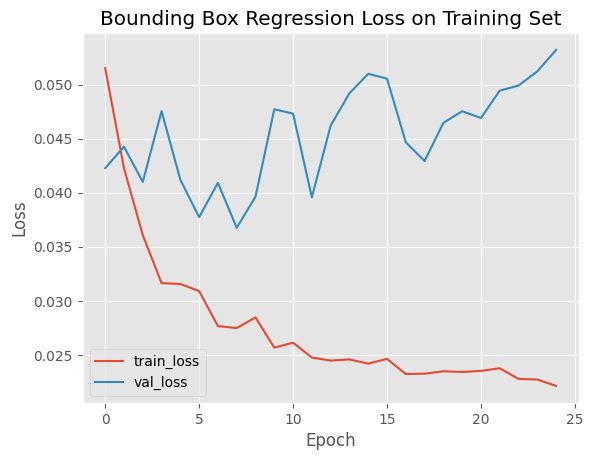

In [20]:
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)


In [ ]:
# Carrando o object detector
model = load_model(MODEL_PATH)

### Realização de predições com o modelo

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


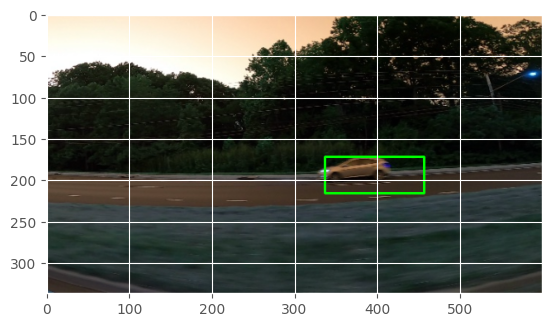

In [ ]:
# Caminho para imagem teste
imagePath = "/kaggle/input/car-object-detection/data/testing_images/vid_5_29460.jpg"

# Carregamento e pre-processamento da imagem teste
image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Realizando predições com o modelo treinado
preds = model.predict(image)[0]

# Extração da bounding-boxes da predição
(startX, startY, endX, endY) = preds

# Leitura da imagem original e resize
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# Aumento a escala das coordenadas previstas para se igualar com a imagem depois do resize
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

# Desenhar o bounding-box na imagem
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

# Exibição da imagem
plt.imshow(image)